# Twitter Sentiment Analysis

<div>
<img style="float: right;" src="images/sentiment.png" width=250/>
</div>

#### Author: Rachel Fein
## Overview
This analysis was completed for Resale Electronics to properly identify their target audience for their upcoming Twitter Ad Campaign. The goal is to use the sentiment of the user's tweets to identify if they are a part of the target audience for the ad.

The dataset in this analysis comes from CrowdFlower. The dataset contains  9065 tweets that were ranked by humans as having a positive, negative, or neutral sentiment. The final model was a logistic regression and in summary showed:
- The final model had an overall accuracy of 69% at correctly identifying the emotion in unseen tweets.
- The model is best at identifying neutral emotion tweets, with a precision of 73% on unseen data. 
- As a result I recommend that more data is collected to improve the model. 


## Business Problem

This analysis was complete for the Marketing team at Resale Electronics. In preparation for Resale Electronics’ Twitter Ad Campaign the team is in need of a model that can correctly identify their target audience. Their goal is to only have people who have either tweeted positively or neutrally about Apple or Google products included as recipients of their Ad Campaign.  

With each sponsored tweet costing the Resale Electronics`$0.50` to `$2.00` it is crucial that the recipients of the ad campaign are a part of the target audience. Resale Electronics hopes that by only sending their ad to people who are already more likely to buy Apple or Google products based on a user's predetermined view of the brands, will help them avoid sending ads to people who have no chance at being a customer. 


## Data Understanding

The dataset in this analysis comes from CrowdFlower. This analysis used 9,065 tweets that were ranked by humans as having a positive, negative, or neutral sentiment. The dataset had three columns: tweet text, emotion, and product. To answer the business problem only the columns `tweet text` and `emotion` were needed. The target variable was emotion. Specifically the categories positive emotion and neutral emotion were the most important in answering the business problem. People who tweet with positive or neutral sentiment towards the brands are Resale Electronics target audience for their upcoming Twitter Ad Campaign. 

<div>
<img src="attachment:images/sentiment.png" width="500"/>
</div>

In [1]:
# Import everything we will need for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('talk')

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import re


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('always')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# First look at the dataframe
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'latin-1')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
# Take a look at the dataframe basics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# Change column name to product to increase readability 
data.rename(columns={"emotion_in_tweet_is_directed_at": "product",
                     "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [5]:
# See what products are getting tweeted at the most, not relevant to the business problem but still
# good to take a quick look into
def view_percentage(data):
    products = data.value_counts()
    return pd.DataFrame({'Count of Tweets':products,
                  '% of Tweets':products/len(data)*100}).round(2)
view_percentage(data['product'])

,Count of Tweets,% of Tweets
iPad,946,10.40
Apple,661,7.27
iPad or iPhone App,470,5.17
Google,430,4.73
iPhone,297,3.27
Other Google product or service,293,3.22
Android App,81,0.89
Android,78,0.86
Other Apple product or service,35,0.38


In [6]:
# Take a closer look at the target variable: emotions & see what the tweets are mostly
view_percentage(data['emotion'])

,Count of Tweets,% of Tweets
No emotion toward brand or product,5389,59.27
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


In [7]:
# Since "I cant tell" group as it is, is not helpful for the business problem 
# I chose to combine it with the no emotion group since they are similar
data['emotion'].replace("I can't tell", "No emotion toward brand or product", inplace=True)
data['emotion'].value_counts()

No emotion toward brand or product    5545
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [8]:
# Majority are tweets without product indicated are neutral emotion
# this suggests that the tweet is general conversation and not so much geared towards a company
product_missing = data[data['product'].isnull()]
product_missing['emotion'].value_counts()

No emotion toward brand or product    5445
Positive emotion                       306
Negative emotion                        51
Name: emotion, dtype: int64

By far the majority of NaN data in the `product` column are assigned to `No emotion toward brand or product` category, that missing data is fine to keep in our dataframe as the business problem is to find the emotion of the tweets, and so the `product` column will not be used in our model. As long as the tweet is geared to either brand or tech in general those are potential buyers.

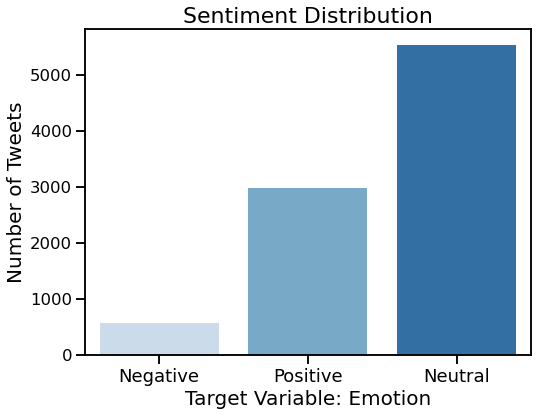

<Figure size 432x288 with 0 Axes>

In [9]:
# Take a better look at our model's target 
labels = ['Negative','Positive', 'Neutral']
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(x= data['emotion'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=22)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Target Variable: Emotion',fontsize=20)
plt.ylabel('Number of Tweets',fontsize=20)
plt.show()

# Save as image
plt.savefig("images/sentiment_dist.png", dpi=150, bbox_inches = "tight")

#### At first glance we notice:
- The majority of the tweets have no emotion followed by positive emotion. The count of negative emotion tweets is far behind them both. The data is imbalanced and this will likely affect the model.
- Tweets that fall under the `I can't tell` sediment are not helpful in answering the business question. I combined that group with the No Emotions group since they are the most similar & relatable.
- There is a large amount of data missing for the `product` column, this is fine since that information will not be used in our model nor is it relevant to the business problem.


## Data Preparation

Overall the dataset was complete and relevant to answering the business problem. The dataset only had one row that had no data for `tweet_text`, which had to be dropped for that reason. The analysis found that there were 27 duplicated rows based off of the `tweet_text` column, the duplicates were dropped. Most rows did not have data for the product column, however that did not cause any issues since the product column was not used in the model and was not relevant to the business problem. 

The datasets' `tweet_text` columns were cleaned to help remove distracting noise that can negatively impact the models’ performance. Stopwords and punctuation were removed. WorldNetLemmatizer was used to reduce the individual words down to their simplest form to help the same word not be viewed as different words by the model.

In [10]:
# Look for blank tweets to remove
data['tweet_text'].isna().sum()

1

In [11]:
# Look at blank tweets to make sure it is safe to remove
data[data['tweet_text'].isnull()]

,tweet_text,product,emotion
6,NaN,NaN,No emotion toward brand or product


In [12]:
# Drop missing tweet and reset the axis
data.drop(6, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [13]:
# Double check the blank tweet is gone
print(data.isna().sum())

tweet_text       0
product       5801
emotion          0
dtype: int64


In [14]:
# Look at shape of dataframe
data.shape

(9092, 3)

In [15]:
# Filtering for dupes
dupes = data[data['tweet_text'].duplicated()]
len(dupes)

27

In [16]:
# Drop the duplicate tweets
data.drop_duplicates(subset='tweet_text',inplace=True)
data.reset_index(drop=True, inplace=True)

In [17]:
# We see that we have removed the dupes
data.shape

(9065, 3)

### Time to split the data to test & training sets
Before we start to clean the tweets we split the data into two groups: testing set & training set. This is done before tweet cleaning to avoid data leakage. Each cleaning step is performed on the test & training sets separately going forward.

In [18]:
# We need to map the target since everything will need to be an int. when modeling
def map_target(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'Negative emotion':
        return 1
    else:
        return 0

In [19]:
# Take a look to make sure everything looks as expected 
data['target'] = data['emotion'].apply(map_target)
data['target'].value_counts(dropna=False,normalize=True)

0    0.609818
2    0.327413
1    0.062769
Name: target, dtype: float64

In [20]:
# Split the data at start to aviod data leakage. 
target = 'target'

y = data[target]
X = data.drop(target, axis=1)

#Stratify=y should help a little with the imbalance of the data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [21]:
# Look at the % of each sediment in the two sets to see how equally divided the data is 
print("Train percent vaccinated:", y_train.value_counts(normalize=True))
print('-------------')
print("Test percent vaccinated: ", y_test.value_counts(normalize=True))

Train percent vaccinated: 0    0.609738
2    0.327449
1    0.062813
Name: target, dtype: float64
-------------
Test percent vaccinated:  0    0.610057
2    0.327305
1    0.062638
Name: target, dtype: float64


In [22]:
# This is to ignore filterwarning that tells me I am working on a copy of my dataset
pd.options.mode.chained_assignment = None

In [23]:
# Make all letters lower case
X_train["tweet_text"] = X_train["tweet_text"].str.lower()
X_test["tweet_text"] = X_test["tweet_text"].str.lower()
X_train.head()

,tweet_text,product,emotion
2772,had no idea that @mention quietly launched its...,NaN,No emotion toward brand or product
9042,you know you've made it to #sxsw when you see ...,iPad,Positive emotion
123,christian #ipad #iphone devs i want to talk to...,iPad or iPhone App,Positive emotion
4646,apple opening a store in downtown atx for this...,Apple,Positive emotion
313,slate see as much traffic to mobile safari as ...,NaN,No emotion toward brand or product


In [24]:
# Tokenize the tweets using TweetTokenizer. This separates the text into a list of words.
tokenizer = TweetTokenizer()

# Applying TweetTokenize to both training and test sets
X_train["tweet_text"]=X_train["tweet_text"].apply(tokenizer.tokenize)
X_test["tweet_text"]=X_test["tweet_text"].apply(tokenizer.tokenize)
X_train.head()

,tweet_text,product,emotion
2772,"[had, no, idea, that, @mention, quietly, launc...",NaN,No emotion toward brand or product
9042,"[you, know, you've, made, it, to, #sxsw, when,...",iPad,Positive emotion
123,"[christian, #ipad, #iphone, devs, i, want, to,...",iPad or iPhone App,Positive emotion
4646,"[apple, opening, a, store, in, downtown, atx, ...",Apple,Positive emotion
313,"[slate, see, as, much, traffic, to, mobile, sa...",NaN,No emotion toward brand or product


In [25]:
# Add the generic stopwords & punctuation we want to be removed from the tweets
stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)

additional_punc = ['...']
stopwords_list.extend(additional_punc)

# Remove stopwords from both training and test set
X_train["tweet_text"] = X_train["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])
X_test["tweet_text"] = X_test["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])
X_train.head()

,tweet_text,product,emotion
2772,"[idea, @mention, quietly, launched, hotpot, re...",NaN,No emotion toward brand or product
9042,"[know, made, #sxsw, see, bunch, grown, men, ho...",iPad,Positive emotion
123,"[christian, #ipad, #iphone, devs, want, talk, ...",iPad or iPhone App,Positive emotion
4646,"[apple, opening, store, downtown, atx, wknd, ....",Apple,Positive emotion
313,"[slate, see, much, traffic, mobile, safari, ap...",NaN,No emotion toward brand or product


In [26]:
# View stopwords
stopwords_list[-10:]

['\\', ']', '^', '_', '`', '{', '|', '}', '~', '...']

In [27]:
# View stopwords
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
# Prep to remove words with less than two characters, short words add distracting noise
shortword = re.compile(r'\W*\b\w{1,3}\b')

def cleaner(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'rt[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', str(tweet)) # remove hyperlink in tweet
    tweet = re.sub(r',', '', str(tweet)) # remove commas 
    tweet = shortword.sub('', str(tweet)) # remove short words 
    tweet = re.sub(r'[^\w\s]', '', str(tweet)) # removes punctuations 
    
    return tweet

# Apply cleaner funtion to train set
X_train["tweet_text"] = X_train["tweet_text"].apply(cleaner)

# Double check tweets look as expected
X_train.head(5)

,tweet_text,product,emotion
2772,idea quietly launched hotpot review product l...,NaN,No emotion toward brand or product
9042,know made sxsw bunch grown hooting getting ipad,iPad,Positive emotion
123,christian ipad iphone devs want talk sxsw mayb...,iPad or iPhone App,Positive emotion
4646,apple opening store downtown wknd time sxsw i...,Apple,Positive emotion
313,slate much traffic mobile safari ipad sxsw ele...,NaN,No emotion toward brand or product


In [29]:
# Apply cleaner funtion to test set
X_test["tweet_text"] = X_test["tweet_text"].apply(cleaner)

# Double check tweets look as expected
X_test.head(5)

,tweet_text,product,emotion
5978,austin know little iphone android love music ...,NaN,No emotion toward brand or product
4536,anyone know store sxsw still ipad stock,iPad,Positive emotion
3892,exhibit hall open sxsw visit chance ipad,iPad,Positive emotion
5320,want micro charger samsung android kindle sx...,NaN,No emotion toward brand or product
6530,google launch major social network called ci...,NaN,No emotion toward brand or product


In [30]:
# We use a lemmatizer, this reduces words to their simplest form. This helps reduce some distracting noise
wordnet_tokenizer = WordNetLemmatizer()
X_train["tweet_text"] = X_train["tweet_text"].apply(wordnet_tokenizer.lemmatize)
X_test["tweet_text"] = X_test["tweet_text"].apply(wordnet_tokenizer.lemmatize)

In [31]:
# Double check tweets look as expected
X_test['tweet_text'][:5]

5978     austin know little iphone android love music ...
4536             anyone know  store sxsw still ipad stock
3892            exhibit hall open sxsw visit chance ipad 
5320      want micro charger samsung android kindle sx...
6530      google launch major social network called ci...
Name: tweet_text, dtype: object

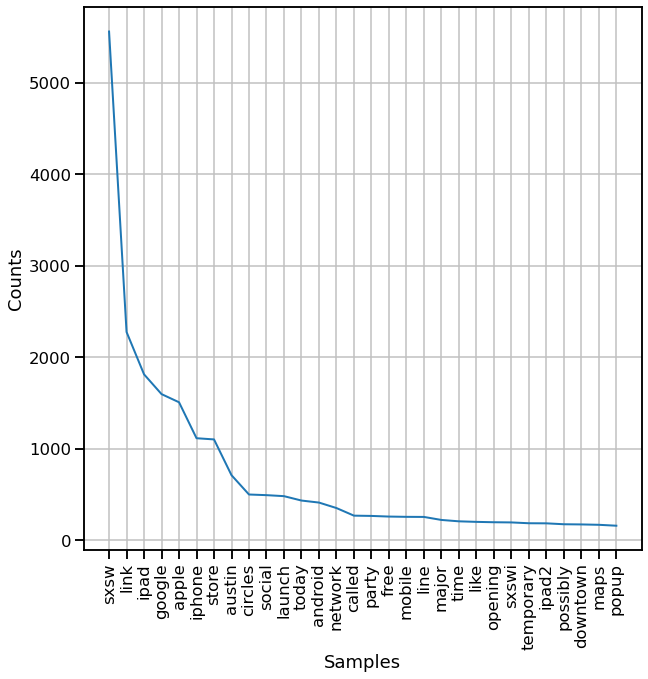

In [32]:
# Veiw most common words by number of occurances for all tweets
sentiment_words = ''.join([word for word in X_train['tweet_text']])
list_words = [ x for x in sentiment_words.split()]
fdist = nltk.FreqDist(list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


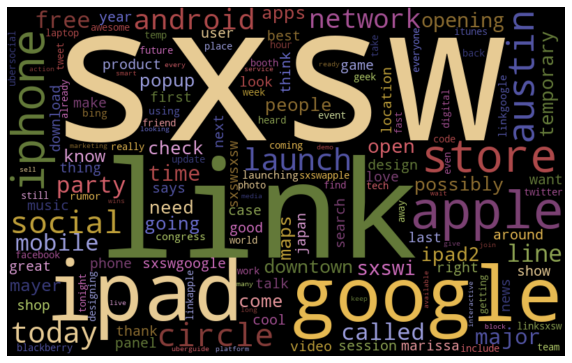

In [33]:
# Building a wordcloud on the data from all tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42,
                      colormap='tab20b', collocations = False,
                      max_words = 150).generate(sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

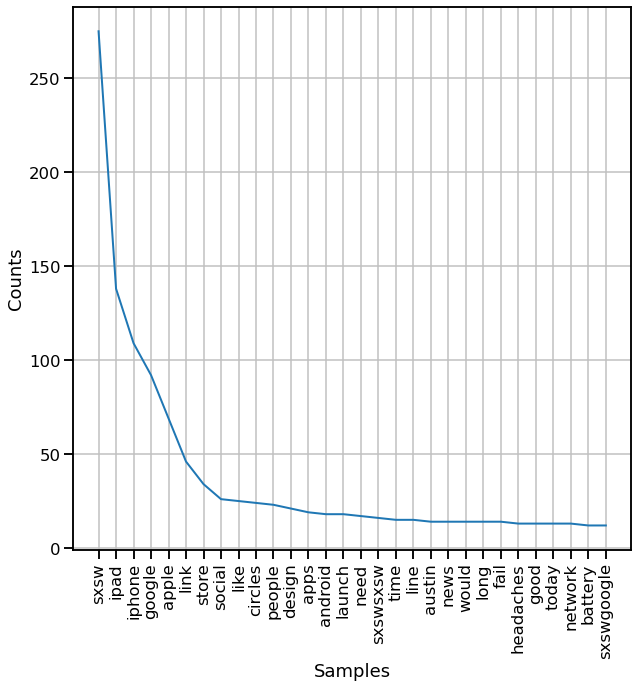

In [34]:
# Lets see some of the most common words in negative tweets
neg = X_train[X_train["emotion"] == 'Negative emotion']
neg_sentiment_words = ''.join([word for word in neg['tweet_text']]) ##words from the tweets that are negative
neg_list_words = [ x for x in neg_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(neg_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

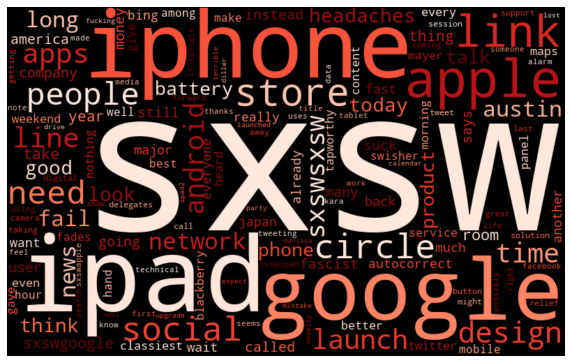

In [35]:
# Building a wordcloud from the negative tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42,
                      collocations = False, max_words = 150,
                      colormap='Reds').generate(neg_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

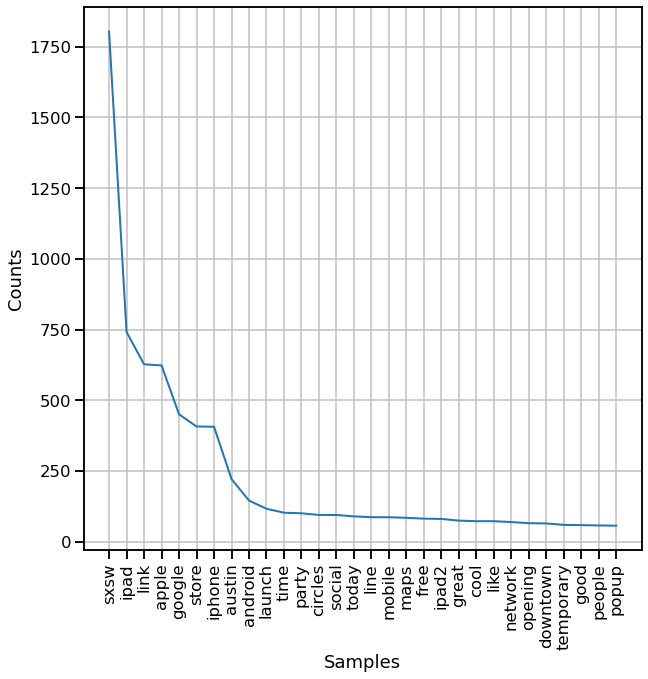

In [36]:
# Lets see some of the most common words in positive tweets
pos = X_train[X_train["emotion"] == 'Positive emotion']
pos_sentiment_words = ''.join([word for word in pos['tweet_text']]) 
pos_list_words = [ x for x in pos_sentiment_words.split()] 
fdist = nltk.FreqDist(pos_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

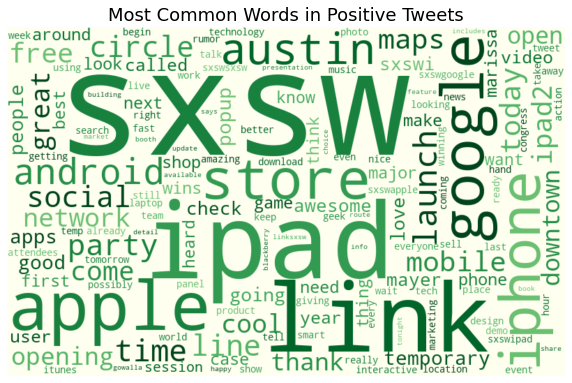

<Figure size 432x288 with 0 Axes>

In [37]:
# Make a darker cmap for the wordcloud
dark_greens = mpl.cm.Greens(np.linspace(0,1,20))
dark_greens = mpl.colors.ListedColormap(dark_greens[10:,:-1])

# Building a wordcloud words from positive tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=19,
                      collocations = False, max_words = 150,
                      colormap=dark_greens, background_color='ivory').generate(pos_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Positive Tweets')
plt.axis('off')
plt.show()

# Save image 
plt.savefig("images/positivecloud.png", dpi=150, bbox_inches = "tight")

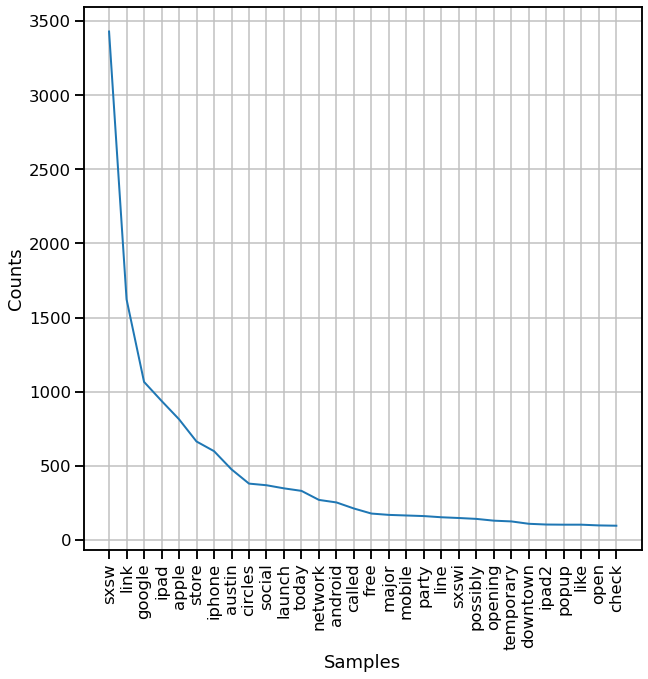

In [38]:
# Lets see some of the most common words in neutral tweets
neutral = X_train[X_train["emotion"] == 'No emotion toward brand or product']
neutral_sentiment_words = ''.join([word for word in neutral['tweet_text']]) 
neutral_list_words = [ x for x in neutral_sentiment_words.split()] 
fdist = nltk.FreqDist(neutral_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

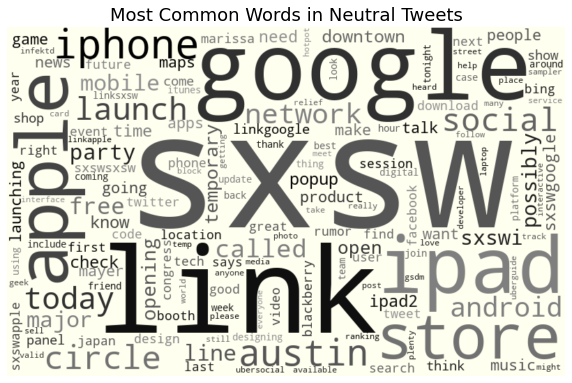

<Figure size 432x288 with 0 Axes>

In [39]:
# Make a darker cmap for the wordcloud
dark_greys = mpl.cm.Greys(np.linspace(0,1,20))
dark_greys = mpl.colors.ListedColormap(dark_greys[10:,:-1])

# Building a wordcloud words from the neutral/no emotion tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=18,
                      collocations = False, max_words = 150,
                      colormap=dark_greys, background_color='ivory').generate(neutral_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Neutral Tweets')
plt.show()

# Save as image
plt.savefig("images/neutralcloud.png", dpi=150, bbox_inches = "tight")

Interesting that sxsw and austin come up in both positive and negative tweets. After a google search I found out that SXSW is a annual festival in Austin, Texas.

## Data Modeling

The datasets were vectorized using CountVectorizer so the data could be modeled. To help interpret each model’s performance a function was made to view the classification reports and a confusion matrix

The final model was a Logistic Regression model. Other models were tested such as RandomForest and  MultNB. All models went through hyperparameter tuning using GridsearchCV. 

SMOTE and RandomOverSampler were used to try to help with the fact that the data is imbalanced. However both those methods actually hurt the model’s performance so neither were used in the final model.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
# Instantiate a vectorizer using CountVectorizer. A max_df =.95 means that words in over 95% tweets are not used
vec = CountVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2))

# Fit the vectorizer on X_train["text"] and transform it
X_train_vec = vec.fit_transform(X_train['tweet_text'])

# transform the vectorizer on X_train["text"]
X_test_vec = vec.transform(X_test['tweet_text']) 

# Visually inspect the vectorized train data
pd.DataFrame.sparse.from_spmatrix(X_train_vec, columns=vec.get_feature_names())

,1000,100s,100s emails,11ntc,11ntc sxsw,11pm,12th,12th zaarlyiscoming,1300,1406,...,ûïbest,ûïbest startups,ûïcheck,ûïcheck offers,ûïline,ûïline moving,ûïwin,ûïwin sxsw,ûòand,ûòand probably
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Make a function that we can use to view the different model's performance
def model_eval_vec(model, X_test_vec, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    
    # Get Predictions/ Classification Report
    y_hat_train = model.predict(X_train_vec)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_vec)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))
    
    #Print just the two f1 scores since that is what we will be uses to grade models performance
    print("---------------------------------------")
    
    print(f'f1 train set: {metrics.f1_score(y_train,y_hat_train, average="weighted")}')
    print(f'f1 test set: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
    
    print("---------------------------------------")

    #print a confusion matrix
    print('Confusion matrix for test set:')
    plot_confusion_matrix(model,X_test_vec,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.99      0.97      4145
    Negative       0.98      0.91      0.95       427
    Positive       0.97      0.92      0.94      2226

    accuracy                           0.96      6798
   macro avg       0.97      0.94      0.95      6798
weighted avg       0.96      0.96      0.96      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.70      0.87      0.78      1383
    Negative       0.55      0.30      0.39       142
    Positive       0.63      0.41      0.50       742

    accuracy                           0.68      2267
   macro avg       0.63      0.53      0.55      2267
weighted avg       0.67      0.68      0.66      2267

---------------------------------------
f1 train set: 0.957364487639316
f1 test set: 0.6617071509516442
---------------------------------------
Confusion matrix 

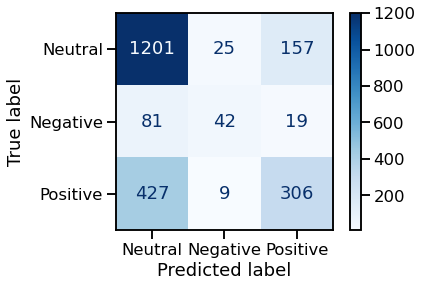

In [42]:
# Start with a baseline model, from there we will tune and improve upon the model
rf_base = RandomForestClassifier()
model = rf_base.fit(X_train_vec,y_train)

model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

Since the ratio of negative, positive, and neutral tweets is imbalanced we will see if SMOTE technique will improve model performance 

In [43]:
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_vec, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 



2    4145
1    4145
0    4145
Name: target, dtype: int64


In [44]:
# Make function to view model performance with SMOTE set
from sklearn import metrics
def model_eval_smote(model, X_test_vec, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6), average="weighted"):
    # Get Predictions/Classification Report
    y_hat_train = model.predict(X_train_resampled)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train_resampled, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_vec)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))

    
    # Print just the two f1 scores since that is what we will be uses to grade models performance 
    print("---------------------------------------")
    
    print(f'f1 train set: {metrics.f1_score(y_train_resampled,y_hat_train, average="weighted")}')
    print(f'f1 test set: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
    
    print("---------------------------------------")
    
    # Print a confusion matrix
    sns.set_style(None)
    plot_confusion_matrix(model,X_test_vec,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.96      0.95      0.96      4145
    Negative       0.85      0.97      0.90      4145
    Positive       0.92      0.80      0.86      4145

    accuracy                           0.91     12435
   macro avg       0.91      0.91      0.91     12435
weighted avg       0.91      0.91      0.91     12435

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.75      0.59      0.66      1383
    Negative       0.27      0.44      0.33       142
    Positive       0.48      0.61      0.54       742

    accuracy                           0.59      2267
   macro avg       0.50      0.55      0.51      2267
weighted avg       0.63      0.59      0.60      2267

---------------------------------------
f1 train set: 0.9055052185389445
f1 test set: 0.5993167933588421
---------------------------------------


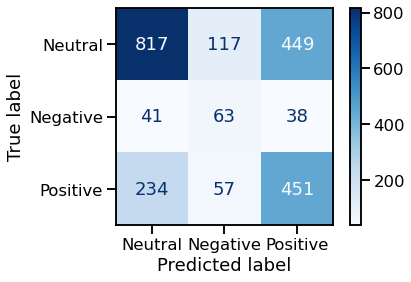

In [45]:
# See how the base model runs with SMOTE 
model = rf_base.fit(X_train_resampled, y_train_resampled)

model_eval_smote(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

SMOTE made the model worse, lets try using RandomOverSampler to see if that helps.

In [46]:
# Lets see if RandomOverSampler helps
ROS = RandomOverSampler()
X_train_ros, y_train_ros = ROS.fit_resample(X_train_vec, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_ros).value_counts()) 



2    4145
1    4145
0    4145
Name: target, dtype: int64


In [47]:
# Make function to view model performance with RandomOverSampler
from sklearn import metrics
def model_eval_ros(model, X_test_vec, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6), average="weighted"):
    # Get Predictions
    y_hat_train = model.predict(X_train_ros)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train_ros, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_vec)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))

    
   # Print just the two f1 scores since that is what we will be uses to grade models performance
    print("---------------------------------------")
    
    print(f'f1 train set: {metrics.f1_score(y_train_ros,y_hat_train, average="weighted")}')
    print(f'f1 test set: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
    
    print("---------------------------------------")
    
    # Print a confusion matrix
    sns.set_style(None)
    plot_confusion_matrix(model,X_test_vec,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.98      0.94      0.96      4145
    Negative       0.99      1.00      0.99      4145
    Positive       0.95      0.97      0.96      4145

    accuracy                           0.97     12435
   macro avg       0.97      0.97      0.97     12435
weighted avg       0.97      0.97      0.97     12435

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.72      0.78      0.75      1383
    Negative       0.34      0.39      0.36       142
    Positive       0.59      0.47      0.52       742

    accuracy                           0.66      2267
   macro avg       0.55      0.55      0.55      2267
weighted avg       0.65      0.66      0.65      2267

---------------------------------------
f1 train set: 0.97231800322201
f1 test set: 0.6521911137343097
---------------------------------------


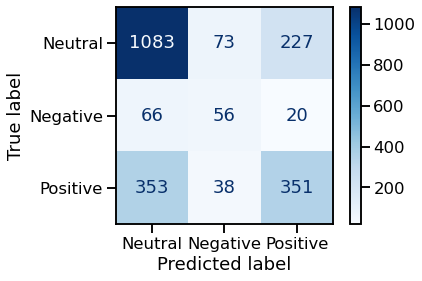

In [48]:
# See how same model does but with RandomOverSampler
model = rf_base.fit(X_train_ros, y_train_ros)

model_eval_ros(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

RandomOverSampler did not help. 

Next, we try to improve upon the random forest model to see if we can get that f1 score up for the test data.

In [49]:
# Use gridsearch to find a better RandomForest model
param = {'criterion': ['gini', 'entropy'],
         'n_estimators':[150, 200],
         'min_samples_split': [6, 8],
         'max_depth': [80, 100]
    
}

gridsearch_rf = GridSearchCV(estimator=rf_base,
                          param_grid=param, cv= 3, scoring='f1_weighted')

# Run search & takes a min or two
gridsearch_rf.fit(X_train_vec,y_train)
gridsearch_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_split': 6,
 'n_estimators': 200}

In [50]:
# Use the found parameters to tune the model one more time to find the best mix
param = {'criterion': ['entropy'],
         'n_estimators':[100],
         'min_samples_split': [4,6],
         'max_depth': [100, 200]
    
}

gridsearch_rf = GridSearchCV(estimator=rf_base,
                          param_grid=param, cv=3, scoring="f1_weighted")

#Run search & takes a min or two
gridsearch_rf.fit(X_train_vec,y_train)
gridsearch_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 200,
 'min_samples_split': 6,
 'n_estimators': 100}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.88      0.99      0.93      4145
    Negative       0.98      0.76      0.86       427
    Positive       0.97      0.80      0.88      2226

    accuracy                           0.91      6798
   macro avg       0.95      0.85      0.89      6798
weighted avg       0.92      0.91      0.91      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.69      0.91      0.78      1383
    Negative       0.72      0.22      0.34       142
    Positive       0.69      0.36      0.47       742

    accuracy                           0.69      2267
   macro avg       0.70      0.50      0.53      2267
weighted avg       0.69      0.69      0.65      2267

---------------------------------------
f1 train set: 0.9113888707380915
f1 test set: 0.6543753247421551
---------------------------------------
Confusion matrix

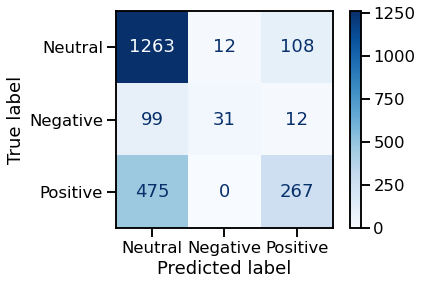

In [51]:
# Fit the model to the best parameters found and run model
params_rf = gridsearch_rf.best_params_
model = RandomForestClassifier(**params_rf)
model.fit(X_train_vec, y_train)
model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

RandomForest isnt producing a good model, lets try a Logistic Regression model & see if that will improve the results

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.91      0.98      0.94      4145
    Negative       0.98      0.79      0.88       427
    Positive       0.95      0.86      0.90      2226

    accuracy                           0.93      6798
   macro avg       0.95      0.88      0.91      6798
weighted avg       0.93      0.93      0.93      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.73      0.83      0.77      1383
    Negative       0.49      0.27      0.35       142
    Positive       0.61      0.50      0.55       742

    accuracy                           0.69      2267
   macro avg       0.61      0.53      0.56      2267
weighted avg       0.67      0.69      0.67      2267

---------------------------------------
f1 train set: 0.925711247273958
f1 test set: 0.6739327980727721
---------------------------------------
Confusion matrix 

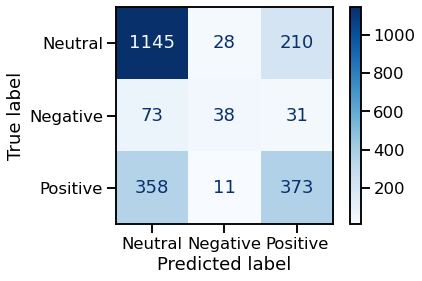

In [52]:
# Start with a basic logistic regression model 
logreg = LogisticRegression(max_iter=500)
model = logreg.fit(X_train_vec,y_train)
model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

In [53]:
# Tune model to try to improve f1 score
# The saga solver, is causing a warning 
model = LogisticRegression(max_iter = 500)

param = {'penalty': ['l2', 'l1'],
         'solver': ['liblinear'],
         'C': [1, 5, 10]}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv=3, scoring="f1_weighted")

#Run search & takes a min or two
gridsearch.fit(X_train_resampled,y_train_resampled)
gridsearch.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [54]:
# Since saga solver was causing a warning, I decided to only use liblinear as a solver
param = {'penalty': ['l2', 'l1'],
         'solver': ['liblinear'],
         'C': [1, 5, 10]}

gridsearch_logreg = GridSearchCV(estimator=logreg,
                          param_grid=param, cv=3, scoring="f1_weighted")

#Run search & takes a min or two
gridsearch_logreg.fit(X_train_vec,y_train)
gridsearch_logreg.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.88      0.97      0.92      4145
    Negative       0.99      0.68      0.81       427
    Positive       0.93      0.81      0.87      2226

    accuracy                           0.90      6798
   macro avg       0.93      0.82      0.87      6798
weighted avg       0.90      0.90      0.90      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.72      0.85      0.78      1383
    Negative       0.52      0.23      0.31       142
    Positive       0.62      0.49      0.55       742

    accuracy                           0.69      2267
   macro avg       0.62      0.52      0.55      2267
weighted avg       0.68      0.69      0.67      2267

---------------------------------------
f1 train set: 0.8978897144891359
f1 test set: 0.6731654525016976
---------------------------------------
Confusion matrix

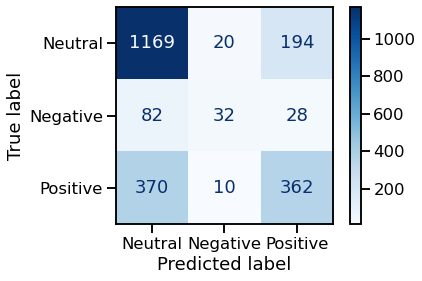

In [55]:
# View log reg model after tuning
params_logreg = gridsearch_logreg.best_params_
model = LogisticRegression(max_iter=500, **params_logreg)
model.fit(X_train_vec,y_train)
model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

The Logistic Regression model without tuning performed a little bit better.

In [56]:
# Try MultinomialNB model 
mult = MultinomialNB()
param = {'alpha':[0.1,1]}

gridsearch = GridSearchCV(estimator=mult,
                          param_grid=param, cv= 3, scoring="f1_weighted" )

#Run search & takes a min or two
gridsearch.fit(X_train_vec,y_train)
gridsearch.best_params_


{'alpha': 1}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.87      0.85      0.86      4145
    Negative       0.67      0.60      0.64       427
    Positive       0.76      0.80      0.78      2226

    accuracy                           0.82      6798
   macro avg       0.76      0.75      0.76      6798
weighted avg       0.82      0.82      0.82      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.74      0.76      0.75      1383
    Negative       0.51      0.25      0.33       142
    Positive       0.54      0.57      0.55       742

    accuracy                           0.67      2267
   macro avg       0.60      0.52      0.55      2267
weighted avg       0.66      0.67      0.66      2267

---------------------------------------
f1 train set: 0.8173087937838894
f1 test set: 0.6601906097532559
---------------------------------------
Confusion matrix

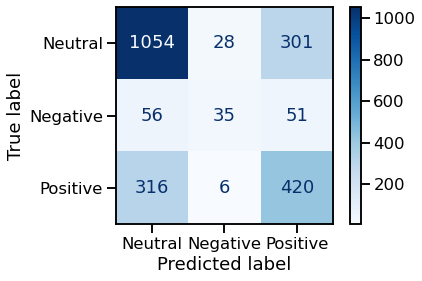

In [57]:
# View the multNB model
params_multNB = gridsearch.best_params_
model = MultinomialNB(**params_multNB)
model.fit(X_train_vec,y_train)
model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

#### The best model was the logistic regression model; 
Lets go back and tune the parameters a little more see if we can get anything better

In [58]:
# recal what the parameters were from tuning for log reg model 
params_logreg

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [59]:
# but actually the signature parameters were better
LogisticRegression(max_iter=500)

LogisticRegression(max_iter=500)

In [60]:
# Let try using the lbfgs solver which is the signature solver for log reg 
param_final = {'penalty': ['l2'],
         'solver': ['lbfgs'],
         'C': [1, 10]}

gridsearch_final = GridSearchCV(estimator=logreg,
                          param_grid=param_final, cv=3, scoring="f1_weighted")

#Run search & takes a min or two
gridsearch_final.fit(X_train_vec,y_train)
gridsearch_final.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.91      0.98      0.94      4145
    Negative       0.98      0.79      0.88       427
    Positive       0.95      0.86      0.90      2226

    accuracy                           0.93      6798
   macro avg       0.95      0.88      0.91      6798
weighted avg       0.93      0.93      0.93      6798

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.73      0.83      0.77      1383
    Negative       0.49      0.27      0.35       142
    Positive       0.61      0.50      0.55       742

    accuracy                           0.69      2267
   macro avg       0.61      0.53      0.56      2267
weighted avg       0.67      0.69      0.67      2267

---------------------------------------
f1 train set: 0.925711247273958
f1 test set: 0.6739327980727721
---------------------------------------
Confusion matrix 

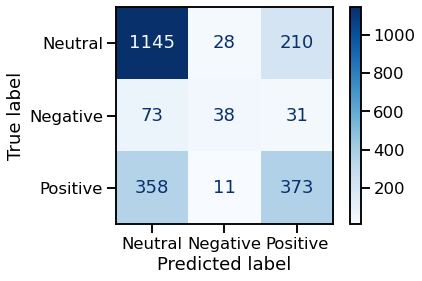

In [61]:
# Fit the model to the best parameteres found and run model
params = gridsearch_final.best_params_
model = LogisticRegression(**params, max_iter=500)
model.fit(X_train_vec, y_train)
model_eval_vec(model,X_test_vec,y_test, classes=['Neutral', 'Negative', 'Positive']);

In [62]:
# Find the accuracy for the final model
y_hat_test = model.predict(X_test_vec)
print("Accuracy for final model's test data:",metrics.accuracy_score(y_test, y_hat_test))

Accuracy for final model's test data: 0.686369651521835


Logistic Regression model did slightly better with the lbfgs solver

## Evaluation

The goal of this analysis was to create a model that would correctly identify Resale Electronics’ target audience for their upcoming Twitter Ad Campaign. Their target audience is those who tweet with positive & neutral emotion towards or about Google or Apple. The hope is that using machine learning to identify those people correctly, will give Resale Electronics a way to narrow down their ad campaign to the correct target audience. 

The analysis does create a model that would aid in narrowing down potential targets for your ad campaign. However, the model has a low accuracy for unseen data. This means that some people who tweet negativity will also be included in the campaign by mistake. As well, there will be some people who tweet positive or neutral and will be incorrectly identify as being negative, therefore falsely removing them from the campaign.

In the end, with each sponsored tweet being so expensive at 50 cents to 2 dollars an ad, it is worth eliminating as many negative tweets as possible. With the knowledge that hardly any people who tweet negatively about Apple or Google go on to purchase their products, an ad to those people could be wasting Resale Electronics budget.

The final model only had an f1 score of 0.674 for the testing data set and 0.926 for the training set. The base model had a score of 0.654, this analysis tuned multiple different types of models trying to raise that testing data f1 score, while tuning was able to raise the score a bit, there is a lot of room for improvement. 

I am confident that using the model will help you find people to include in your target audience for your ad campaign, however I think further analysis would be needed before implementing your campaign. 

## Conclusion
The business problem was to make a model that would identify people who are tweeting positive or neutral tweets about google or apple products. The goal in identifying these people is to narrow down the recipients of your twitter ad campaign.

In summary this analysis showed:
- The final model had an overall accuracy of 69% at correctly identifying the emotion in unseen tweets.
- The model is best at identifying neutral emotion tweets, with a precision of 73% on unseen data. 
- As a result I recommend that more data is collected to improve the model. 

This analysis has gotten you one step closer to correctly identifying and finding your target audience by using machine learning to help rip through all the chaos that is twitter to help you find your potential customers. However, this analysis showed that more information is needed. As a result of the findings, I recommend that you collect more data. Giving more tweets for the model to build off of will improve its performance. Spending the effort to get more data & analyzing the data again can save money in the long run since a well performing model gives you your best shot at finding your correct ad audience. 

Next steps also can include using more complex Deep Natural Language Processing methods such as neural networks.